In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, beta

from GEM import GEM # this is the stick-breaking function

# Breaking a stick

Let's implement the stick breaking construction with $\alpha=1$ and $K=5$ and visualise the weights as pieces of a stick.

Weights, pi = [4.91345486e-01 3.84777732e-01 9.14256050e-02 1.86185431e-02
 2.96648964e-04 3.29526634e-03 8.61386539e-03 1.43875701e-03
 5.04473393e-05 5.09969811e-05]
Sum of weights = 0.9999133477765921 approx 1


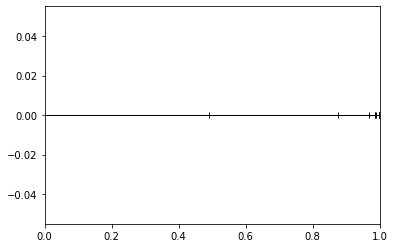

In [45]:
alpha, K = 1., 10
b = beta(1, alpha).rvs(K)
pi = b.copy()
pi[1:] = b[1:]*(1 -b[:-1]).cumprod()

print("Weights, pi =", pi)
print("Sum of weights =", np.sum(pi), "approx 1")

plt.scatter(np.cumsum(pi), np.zeros_like(pi), marker='|', color='k', lw=1)
plt.plot([0,np.sum(pi)], [0,0], 'k-', lw=1)
plt.xlim(0,1)
plt.show()

We can draw many realisations of this process efficiently using the function GEM.

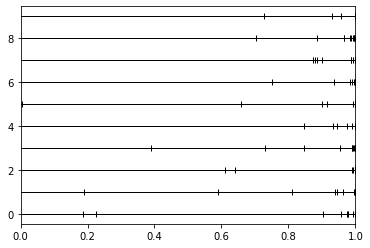

In [46]:
pi = GEM(alpha, K=K, N=10)

for i in range(10):
    Pi = pi[:,i]
    plt.scatter(np.cumsum(Pi), i+np.zeros_like(Pi), marker='|', color='k', lw=1)
    plt.plot([0,np.sum(Pi)], [i,i], 'k-', lw=1)
    
plt.xlim(0,1)
plt.show()

# Distributions on the interval [0,1]

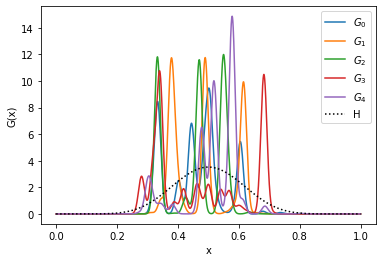

In [2]:
# parameters of the DP
alpha, H = 5, beta(10, 10)

# How many realisations to draw from DP
N = 5

# Maximum number of clusters
K = 100

# Break the stick
pi_k = GEM(alpha, K=K, N=N)

# Draw the atoms
atoms = H.rvs(size=(K, N))

# The distribution G~DP(alpha, H), made smooth by convolving with a Gaussian kernel
sigma = 0.01
G = lambda x: np.sum(pi_k*np.exp(-0.5*((x-atoms)/sigma)**2)/np.sqrt(2*np.pi*sigma**2), axis=0)

# Plot the 5 randoms G distributions
x = np.linspace(0, 1, 10000)
vals = np.array([G(X) for X in x])

for i in range(N):
    plt.plot(x, vals[:,i], label=r"$G_"+str(i)+"$")

plt.plot(x, H.pdf(x), 'k:', label="H")

plt.xlabel("x"); plt.ylabel("G(x)"); plt.legend()
plt.show()


# Distributions on the sphere

In [3]:
class sphere_dist:
    """
    A uniform distribution on the sphere, S2
    """
    
    def rvs(self, size=(1,)):
        """
        Draw random variables
        
        INPUTS
        ------
        size: tuple
            the number (and shape) of points in output array
            
        RETURNS
        -------
        output: array, shape (*size, 2)
            points on sphere exrpessed in polar coords (theta, phi)
        """
        p = norm().rvs(size=(3, *size))
        p /= np.linalg.norm(p, axis=0)
        
        ra = np.arctan2(p[1,...],p[0,...])
        dec = np.pi/2 - np.arccos(p[2,...])
        
        return np.stack((ra, dec), axis=-1)
    

In [4]:
# parameters of the DP
alpha, H = 20, sphere_dist()

# How many realisations to draw from DP
N = 5

# Maximum number of clusters
K = 1000

# Break the stick
pi_k = GEM(alpha, K=K, N=N)

# Draw the atoms
atoms = H.rvs(size=(K, N))


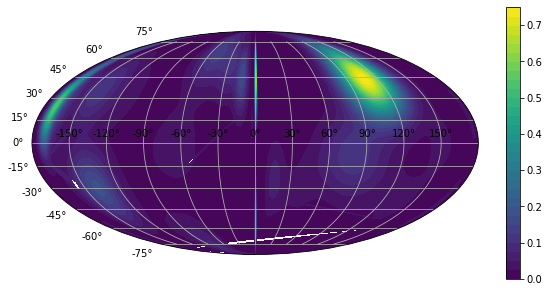

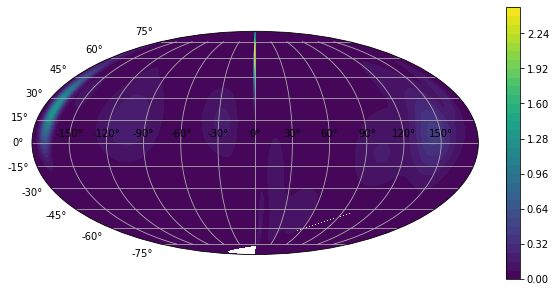

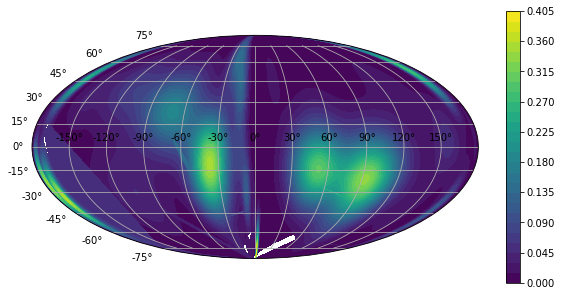

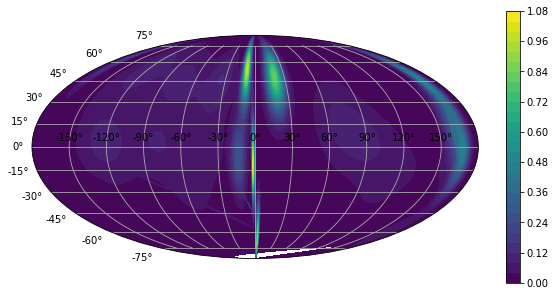

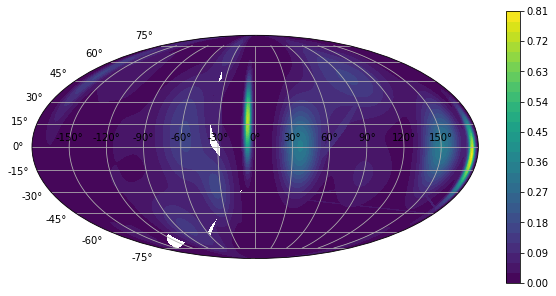

In [5]:
def kernel(ra, dec, ra_0, dec_0, d=0.3):
    ans = np.exp(-0.5*((dec-dec_0)/d)**2)/np.sqrt(2*np.pi*d**2)
    ans *= np.exp(-0.5*((ra-ra_0)/(d*np.sin(ra_0)))**2)/np.sqrt(2*np.pi*d**2*np.sin(ra_0)**2)
    return ans

Ra = np.linspace(-np.pi, np.pi, 300)
Dec = np.linspace(-np.pi/2, np.pi/2, 300)
Ra, Dec = np.meshgrid(Ra, Dec)

for r in range(N):
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111, projection="mollweide")
    ax.grid(True)

    Density = np.sum([pi_k[k,r]*kernel(Ra, Dec, atoms[k,r,0], atoms[k,r,1]) for k in range(K)], axis=0)
    C = ax.contourf(Ra, Dec, Density, 30)
    fig.colorbar(C)
    plt.show()
    